In [138]:
#utils for ClassifierLogisticRegression

def sigmoid(t):
    """Compute the sigmoid function on t."""
    return 1./ (1+ np.exp(-t))


def der_sigmoid(t):
    """Compute derivtive of sigmoid on t"""
    return sigmoid(t)*(1-sigmoid(t))


def log_likelihood_loss(y, tx, w):
    """compute the loss: negative log likelihood."""
    pred = sigmoid(tx.dot(w)) 
    return ((y - pred)**2).mean()



def calculate_gradient(y, x, w):
    """compute the gradient of log_likelihood_loss wrt weights."""
    temp = y.ravel()
    arg = x@w
    s = sigmoid(arg)
    gradient = x.T@(s - temp)
    return gradient


def learning_by_gradient_descent(y, tx, w, gamma, return_gradient = False):
    """
    Do one step of gradient descent using logistic regression.
    Return the loss and the updated w.
    """
    w = w.ravel()
    #compute loss
    loss = log_likelihood_loss(y, tx, w)
    #copmute gradient
    grad = calculate_gradient(y, tx, w)
    #do gradient step 
    w -= gamma*grad

    #if required, return also the gradient
    if return_gradient:
        return loss, w, grad
    return loss, w

In [140]:
#Logistic Regression
class ClassifierLogisticRegression():

    def update_params(self):
        """Update the dictionary containng the parameters"""
        self.params['name'] = self.name
        self.params['lambda_'] = self.lambda_
        self.params['regulairizer'] = self.regularizer
        self.params['gamma'] = self.gamma
        self.params['max_iterations'] = self.max_iterations
        self.params['threshold'] = self.threshold
    
    def __init__(self, lambda_, regularizer, gamma, max_iterations , threshold):
        """ 
            Sets parameters for logistic regression
            Argument:
                - gamma (float)
                - n_iterations (int)
        """

        #A dictionary containing the relevant parameters of the classifier 
        self.params = dict()

        #name of the classifier 
        self.name = 'LogisticRegression'
        
        #weight of the regularization term in the loss
        self.lambda_= lambda_
        
        #kind of regularizer: L1, L2 or None
        self.regularizer = regularizer

        #the step in gradient descent
        self.gamma = gamma

        #the maximum number of iterations
        self.max_iterations = max_iterations

        #threshold in gradient descent
        self.threshold = threshold
        

        self.update_params()

    def train(self, y_train, tx_train, batch_size = -1, verbose = True, tx_validation = None, y_validation = None, store_gradient = False):
        """ 
            Trains the model. It learns a new w with logistic regression. 
            Arguments:
                - tx_train: ndarray matrix of size N*D
                - y_train: ndarray matrix of size D*1
            Hypothesis: tx_train ndd y_train have the same length
        """
        #initialize the weights
        self.w = np.zeros(tx_train.shape[1])
        #store the losses over 1 complete iteration (epoch)
        self.losses = []
        #store the prediction accuracies if validation tests are inputted:
        if (tx_validation is not None) and (y_validation is not None):
            self.pred_accuracies_train = []
            self.pred_accuracies_validation = []
        #store the norm of the gradient if required
        if store_gradient:
            self.stored_gradients = []

        #initiazlie the number of samples
        N = tx_train.shape[0]
        #initialize the batch size
        if batch_size == -1:
            batch_size = N

        #iterate over the dataset
        for iter in range(self.max_iterations):
            
            #loss accumulated over many batches
            acc_loss = 0
            for b in range(0, N, batch_size):  
                
                #perform a gradient step over a batch
                #if required, get also the gradient
                if store_gradient:
                    l, self.w, grad = learning_by_gradient_descent(
                        y_train[b:b+batch_size], 
                        tx_train[b:b+batch_size], 
                        self.w, 
                        self.gamma, 
                        return_gradient = True)
                    
                else:
                    l, self.w = learning_by_gradient_descent(
                        y_train[b:b+batch_size], 
                        tx_train[b:b+batch_size], 
                        self.w, 
                        self.gamma
                        )
            
                #update accumulated loss
                acc_loss += l

            #output the loss if verbose
            if verbose and iter % 100 == 0:
                print("Current iteration={a}, loss={b}".format(a=iter, b=acc_loss))
            
            #if required, store the predictions log
            if (tx_validation is not None) and (y_validation is not None):
                self.pred_accuracies_train += [(self.predict(tx_train) == y_train).mean()]
                self.pred_accuracies_validation += [(self.predict(tx_validation) == y_validation).mean()]

            #if required, store the norm of the gradient
            if store_gradient:
                self.stored_gradients += [np.linalg.norm(grad)]

            #store the loss over an iteration
            self.losses += [acc_loss]
            

            #check if convergence has been achieved
            if len(self.losses) > 1 and np.abs(self.losses[-1] - self.losses[-2]) < self.threshold:
            
                #update internal parameters and exit
                self.params['losses'] = self.losses
                self.params['weights'] = self.w
                print('hit thresh')

                #if accuracies were required:
                if (tx_validation is not None) and (y_validation is not None):
                    self.params['accuyracues_while_training_train'] = self.pred_accuracies_train
                    self.params['accuyracues_while_training_validation'] = self.pred_accuracies_validation                    

                #if required, store the norm of the gradient
                if store_gradient:
                    self.params['stored_gradients'] = self.stored_gradients
                
                break

        #end of training: update internal parameters and exit
        self.params['losses'] = self.losses
        self.params['weights'] = self.w

        #if accuracies were required:
        if (tx_validation is not None) and (y_validation is not None):
            self.params['accuyracues_while_training_train'] = self.pred_accuracies_train
            self.params['accuyracues_while_training_validation'] = self.pred_accuracies_validation
    
        #if required, store the norm of the gradient
        if store_gradient:
            self.params['stored_gradients'] = self.stored_gradients
    
    def predict(self, x):
        """ 
            returns a list of predictions
            Argument:
                - x: a sample vector 1*D 
            Returns : 
                Array[int] 
        """
        pred = sigmoid(x.dot(self.w)) 
        pred = np.rint(pred)
        return pred

In [79]:
#utils for logistic regressin
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from helpers import sample_data, load_data, standardize
#from least_squares import least_squares
from plots import visualization


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
## load data.
height, weight, gender = load_data()

seed = 1
# build sampled x and y.
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)
tx = np.c_[np.ones((y.shape[0], 1)), x]

y = 1.0*y
y = y.ravel()

Current iteration=0, loss=0.25
Current iteration=100, loss=0.06428344044788997
Current iteration=200, loss=0.06098175439136462
Current iteration=300, loss=0.06007486765647419
Current iteration=400, loss=0.05971498996683114
Current iteration=500, loss=0.0595437706795302
Current iteration=600, loss=0.059453448776472725
Current iteration=700, loss=0.0594027437230055
Current iteration=800, loss=0.05937316756979445
Current iteration=900, loss=0.059355501186209


0.92

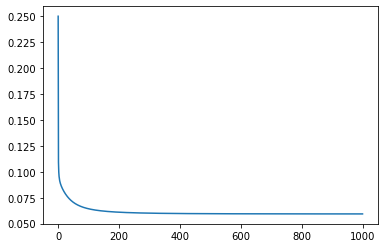

<Figure size 432x288 with 0 Axes>

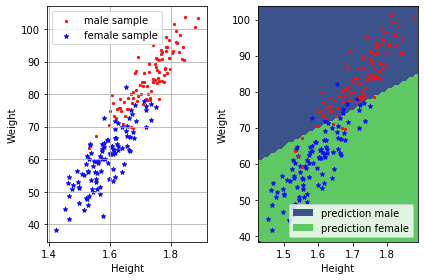

In [97]:
clf = ClassifierLogisticRegression(
    lambda_ = 0, 
    regularizer = None, 
    gamma=0.01, 
    max_iterations = 1000, 
    threshold = 1e-8
    )

clf.train(y_train=y, tx_train=tx, batch_size = -1, tx_validation = tx, y_validation = y)
plt.plot(clf.losses)
fig = plt.figure()
visualization(y, x, mean_x, std_x, clf.w.T, "classification_by_logistic_regression_gradient_descent", True)
(clf.predict(tx) == y).mean()

In [88]:
clf.params.keys()

dict_keys(['name', 'lambda_', 'regulairizer', 'gamma', 'max_iterations', 'threshold', 'losses', 'weights', 'accuyracues_while_training_train', 'accuyracues_while_training_validation'])

In [135]:
def trainig_plots(clf):
    fig, axis = plt.subplots(1, 2, figsize = (20, 5))
    axis[0].plot(clf.params['losses'], label = 'Loss')
    axis[0].set_xlabel('Iteration')
    axis[0].set_ylabel('MSE Loss')
    axis[0].set_title('Loss')
    axis[0].legend()

    axis[1].plot(clf.params['accuyracues_while_training_train'], label = 'accuracy training')
    axis[1].plot(clf.params['accuyracues_while_training_validation'], label = 'accuracy validation')
    axis[1].set_xlabel('Iteration')
    axis[1].set_ylabel('Fraction of success')
    axis[0].set_title('Overfit test')
    axis[1].legend()



Current iteration=0, loss=1.7604718121416005
Current iteration=100, loss=0.6448762448518667


0.92

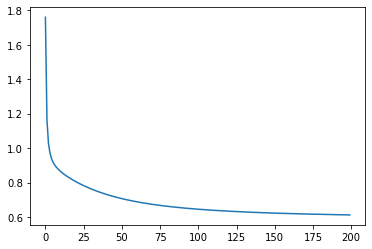

<Figure size 432x288 with 0 Axes>

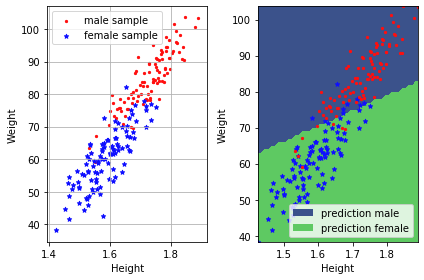

In [22]:
clf = ClassifierLogisticRegression(
    lambda_ = 0, 
    regularizer = None, 
    gamma=0.01, 
    max_iterations = 200, 
    threshold = 1e-8
    )

clf.train(y_train=y, tx_train=tx, batch_size = 20)
plt.plot(clf.losses)
fig = plt.figure()
visualization(y, x, mean_x, std_x, clf.w.T, "classification_by_logistic_regression_gradient_descent", True)
(clf.predict(tx) == y).mean()

In [23]:
def load_csv_data(data_path, sub_sample=False):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1
    
    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids

def preprocessing(y, tx, nan_strategy, standardize_=True, outliers = False):
  """
  Do the preprocessing of the data.
  Argument:
      - y : of shape (N, )
      - tx: of shape (N, D)
      - nan_strategy: string. Defines how we handle the data. One of the following:
          1. 'NanToMean', replaces NaNs with the mean
          2. 'NanToMedian', replaces the NaNs with the median
          3. 'RemoveNan', removes the rows containing the NaNs
          4. 'RemoveNanFeatures' removes the columns with NaNs
          5. 'NanTo0', replaces the NaNs with 0
      - standardize: standardizes the data
      - outliers TODO

  Returns : 
      -(res_y, res_x) : tuple of processed data

  """
  NANVAL = -998
  
  #TODO : outliers
  res_x = tx
  res_y = y
  res_x = np.where(res_x < NANVAL, np.NaN, res_x)

  indices = np.where(np.isnan(res_x))
  if nan_strategy=='NanToMean':
    # Replace with mean
    means = np.nanmean(res_x, axis=0)
    res_x[indices] = np.take(means, indices[1]) 
  elif nan_strategy=='NanToMedian':
    # Replace with median
    medians = np.nanmedian(res_x, axis=0)
    res_x[indices] = np.take(medians, indices[1])
  elif nan_strategy=='RemoveNan':
    # Remove the NaN
    rows_with_nan = ~np.isnan(res_x).any(axis=1)
    res_y, res_x = res_y[rows_with_nan], res_x[rows_with_nan]
  elif nan_strategy=='RemoveNanFeatures':
    # Remove columns with NaN
    columns_with_nan = ~np.isnan(res_x).any(axis=0)
    res_x = res_x[:,columns_with_nan]
  elif nan_strategy == 'OnlyNanFeatures':
    columns_wo_nan = np.isnan(res_x).any(axis=0)
    res_x = res_x[:,columns_wo_nan]
    rows_with_nan = ~np.isnan(res_x).any(axis=1)
    res_y, res_x = res_y[rows_with_nan], res_x[rows_with_nan]
  elif nan_strategy== 'NanTo0':
    # Replace with 0
    res_x = np.nan_to_num(res_x)
  else:
    raise Error('specify a correct strategy')


  if outliers : 
    #TODO remove outliers
    pass
  if standardize_: 
    res_x, _, _ = standardize(res_x)
  return res_y, res_x

In [24]:
def split_data(x, y, ratio, verbose = False):
    n_samples = y_train.shape[0]

    indices = np.random.permutation(n_samples)
    sub_x_1 = x[indices][:int(ratio*n_samples)]
    sub_x_2 = x[indices][int(ratio*n_samples):]

    sub_y_1 = y[indices][:int(ratio*n_samples)]
    sub_y_2 = y[indices][int(ratio*n_samples):]

    if verbose:
        print('ration:\t', ratio)
        print('ratio of samples 1st subset:\t', np.round_((sub_y_1 == 1).sum()/(ratio*n_samples), decimals=2))
        print('ratio of samples 2nd subset:\t', np.round_((sub_y_2 == 1).sum()/((1-ratio)*n_samples), decimals=2))
    return sub_x_1, sub_y_1, sub_x_2, sub_y_2

In [122]:
#real stuff now

TRAIN = '../data/train.csv' # due to directory structure, the data directory is now one directory above this one
TEST = '../data/test.csv'
y, x, ids_train = load_csv_data('../data/train.csv')

In [142]:
clf = ClassifierLogisticRegression(
    lambda_ = 0, 
    regularizer = None, 
    gamma= 1e-5, 
    max_iterations = 100, 
    threshold = 1e-8
    )

strategies = [
    'NanToMean']        #replaces NaNs with the mean

dictionaries = []
for strat in strategies:
    print(strat)
    #clf = ClassifierLinearRegression(lambda_ = 0.2, regularizer = reg)
    y_train, tx_train = preprocessing(y, x, strat, standardize_=True) 
    y_train = (y_train+1)/2
    print('Sanity check :n = ', tx_train.shape[0], 'D = ', tx_train.shape[1])
    tx_train, y_train, tx_validation, y_validation = split_data(tx_train, y_train, ratio = 0.7, verbose = False)
    clf.train(y_train, tx_train, verbose = True, batch_size = 100, tx_validation = tx_validation, y_validation = y_validation, store_gradient=True)
    #dictionary = clf.get_params_and_results(tx_train, tx_validation, y_train, y_validation)
    #dictionaries += [dictionary]
    #print('accuracy_test', np.round(dictionary['accuracy_test'], decimals = 2))
    #print('accuracy_train', np.round(dictionary['accuracy_train'], decimals = 2))
    #print('regularization', clf.regularizer, '\n\n')

NanToMean
Sanity check :n =  250000 D =  30
Current iteration=0, loss=392.391248684327


In [147]:
#the store gradient methods stores the gradient on the last batch iteration if batch == True
len(clf.params['stored_gradients'])

100

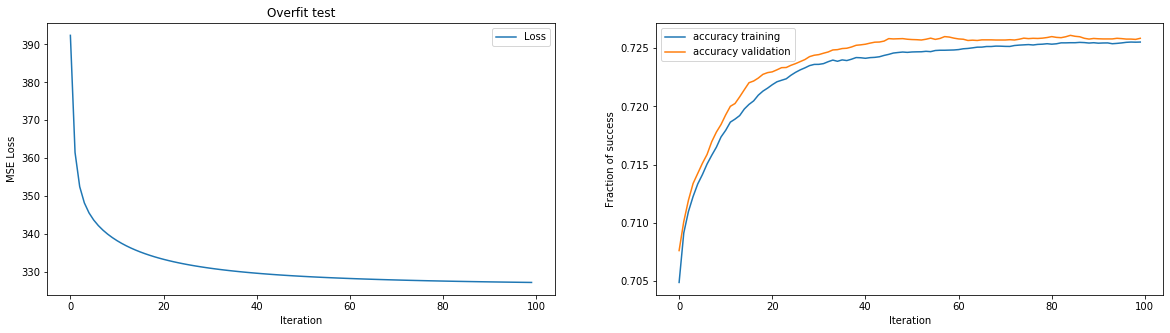

In [148]:
trainig_plots(clf)

Text(0.5, 1.0, 'Norm of gradients')

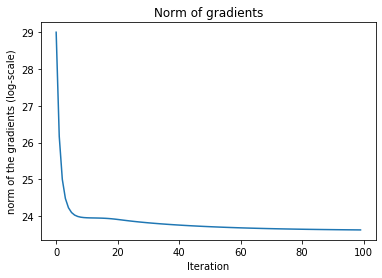

In [153]:
plt.plot(clf.params['stored_gradients'])
plt.ylabel('norm of the gradients (log-scale)')
plt.xlabel('Iteration')
plt.title('Norm of gradients')

In [125]:
(clf.predict(tx_train) == y_train).mean()

0.7242857142857143

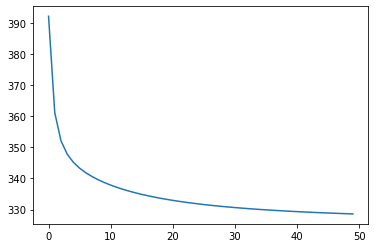

In [61]:
plt.plot(clf.losses)